# Assignment 5 - Reinforcement Learning

## Kate Coulter
Netid:  kvc6

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [7]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [8]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(12, 7, False)
((21, 7, False), 0, False)


**ANSWER**

In [9]:
# using the code run above, play 50 hands of blackjack

import numpy as np

#initialize 
game = Blackjack()

#create variables to measure outcome of game
wins = 0
losses = 0
ties = 0

#play 50 rounds
for i in range(1,51):
    #deal cards
    s0 = game.deal()
    print('\nRound {}'.format(i))
    
    while True:
        #user choice - hit or stay
        action = input('Choose action: 0 for stay, 1 for hit | Selected: ')
        s1 = game.step(action)
        
        #display current hand
        print('Hand: {}'.format(s1))
        if s1[2] == True:
            
            #if win
            if s1[1] == 1:
                print('Result: Win!')
                wins = wins + 1
            
            #if tie
            elif s1[1] == 0:
                print('Result: Draw')
                ties = ties + 1
                
            #if loss
            else:
                print('Result: Loss')
                losses = losses + 1
            break
            
print('\nResults over last set of games:\n')
print('Wins: {}'.format(wins))
print('Ties: {}'.format(ties))
print('Losses: {}'.format(losses))


Round 1
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((18, 4, True), 1.0, True)
Result: Win!

Round 2
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((17, 7, False), 1.0, True)
Result: Win!

Round 3
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((12, 7, False), -1.0, True)
Result: Loss

Round 4
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((9, 4, False), -1.0, True)
Result: Loss

Round 5
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((20, 10, False), 1.0, True)
Result: Win!

Round 6
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((15, 9, False), -1.0, True)
Result: Loss

Round 7
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((11, 10, False), -1.0, True)
Result: Loss

Round 8
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((7, 1, False), -1.0, True)
Result: Loss

Round 9
Choose action: 0 for stay, 1 for hit | Selected: 1
Hand: ((20, 6, False), 1.0, True)
Result: Win!

Round 10
Choose action: 0 for st

In [10]:
# find overall average reward

# measure reward for each case as win = 1, lose = -1, tie = 0
reward = (wins*1 + losses*-1) / 50

print('Average Reward / Game: {}'.format(reward))
print('Total Resulting Reward: {}'.format(reward*50))

Average Reward / Game: 0.04
Total Resulting Reward: 2.0


## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

Beginning simulations. 

Beginning 10k predictions. 

10k prediction complete. 

Plotting Results. 



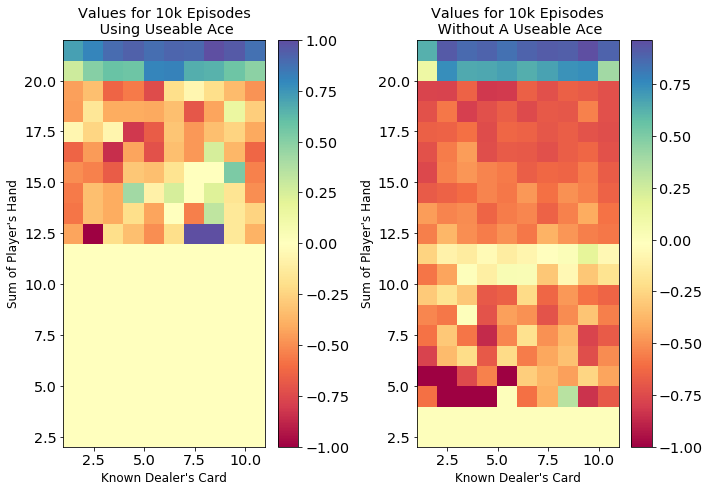

In [11]:
# a
# use monte carlo to calculate expected returns from each state

from collections import defaultdict
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'font.size': 12,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'axes.grid': 'false'}
pylab.rcParams.update(params)


# create functions, and data structures needed for provided policy
def testpolicy(state):
    players_hand,_,_ = state
    
    # policy to hit if cards equal 19 or less
    if players_hand < 20:
        return 1
    # stay if 20 or 21
    else:
        return 0

# create prediction function
def predMC(game, policy, num_episodes):
    # initialize 
    
    # dict of state values
    states = defaultdict(float)
    # dict of state returns
    returns = defaultdict(float)
    # dict of return count to state
    returns_ct = defaultdict(float)
    # save average reward / episode
    avgreward = []
    
    # counters for episodes and rewards
    reward_n = 0
    episodes_n = 0
    
    # simulation!
    for episode_num in range(1, num_episodes+1):
        #start new game
        curr_state = game.deal()
        
        #define episode as one hand prior to completion
        episode = []
        
        counter = 0
        while True:
            
            # given current hand, decide between hit or stay
            action = policy(curr_state)
            
            # update the game with the action from policy
            next_state, reward, game_over = game.step(action)
            
            # save current state and associated reward
            episode.append((curr_state, reward))
            
            # check for when game is finished, if so add episode's reward to total reward counter
            if game_over:
                reward_n += reward
                break
                
            # otherwise continue playing
            curr_state = next_state
            
        # update counter for episode count
        episodes_n += 1
        
        # calculate current reward to use 
        avgreward.append(reward_n/float(episodes_n))
        
        # gather information for all states appearing in episode
        for i in range(len(episode)):
            state, reward = episode[i]
            
            # create variable for return after first s
            initial = 0
            for j in range(i, len(episode)):
                initial += episode[j][1]
                
            # append initial value to returns[s]
            returns[state] += initial
            # update current returns count to calculate average reward over number of visits to state
            returns_ct[state] += 1
            
            # calculate values for s from average of returns to s
            states[state] = returns[state]/returns_ct[state]
        
    return states, avgreward
    
# initialize 
bj_game = Blackjack()

print('Beginning simulations. \n')
print('Beginning 10k predictions. \n')
values10k, avgreward10k = predMC(bj_game, testpolicy, 10000)
print('10k prediction complete. \n')


# create plot environment and variables needed to show expected returns for each of the two states
print('Plotting Results. \n')

x = np.arange(1, 12, 1)
y = np.arange(2, 23, 1)

# create mesh grid for all possible x, y
X, Y = np.meshgrid(x, y)

# useable ace case
useA10k = np.array([values10k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
useA10k = useA10k.reshape(X.shape)

# un-useable ace case
unA10k = np.array([values10k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
unA10k = unA10k.reshape(X.shape)

# create plots
plt.figure(figsize = (10,7))

# question 1 -
# plot useable case
plt.subplot(1,2,1)
plt.title('Values for 10k Episodes\n Using Useable Ace')
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.pcolor(X,Y,useA10k, cmap='Spectral')
plt.colorbar()

# question 2 - 
# plot un-useable case
plt.subplot(1,2,2)
plt.title('Values for 10k Episodes\n Without A Useable Ace')
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.pcolor(X,Y,unA10k, cmap='Spectral')
plt.colorbar()

plt.tight_layout()
plt.show()


(a part 1) continued -

The two plots shown above display the expected returns for each state, the first being the case that you had a useable ace and the second the case without a useable ace. These two plots display the results from 10,000 simulations. As you can see, the case where aces are allowed shows that when the sum of the player's hand has a value roughly between 12.5 and 20 the player's expected returns are typically negative, although not at every single point in this range. In contrast, when they player's hand has a value smaller than 12.5, expected returns are 0 and when the value is greater than 20 the expected return is positive. For cases without a useable ace, values at or lower than 20 are generally negative, although two bands exist where the expected return is 0 at values of 11 and another band for values below 4. In both cases there is obvious noise, which is expected having run only 10,000 simulations which, in this case, is not enough for the monte carlo policy to estimate correctly.

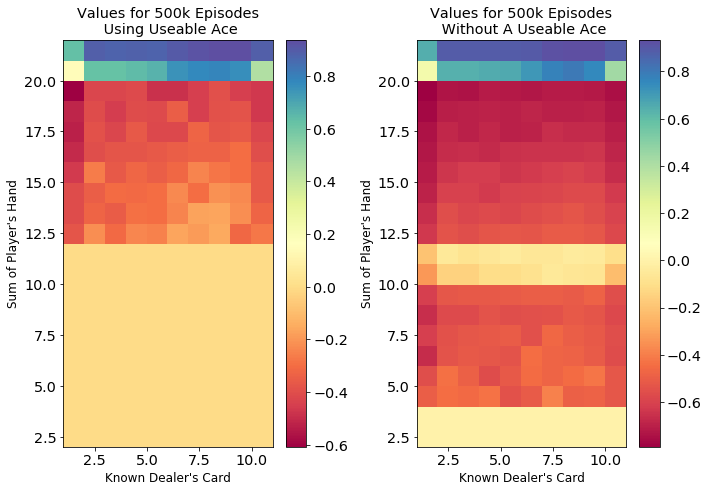

In [12]:
# a continued - 
# repeat process for 500k episodes

# create variables needed
values500k, avgreward500k = predMC(bj_game, testpolicy, 500000)

# useable ace case
useA500k = np.array([values500k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
useA500k = useA500k.reshape(X.shape)

# un-useable ace case
unA500k = np.array([values500k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
unA500k = unA500k.reshape(X.shape)

# create plots
plt.figure(figsize = (10,7))

# question 1 -
# plot useable case
plt.subplot(1,2,1)
plt.title('Values for 500k Episodes\n Using Useable Ace')
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.pcolor(X,Y,useA500k, cmap='Spectral')
plt.colorbar()

# question 2 - 
# plot un-useable case
plt.subplot(1,2,2)
plt.title('Values for 500k Episodes\n Without A Useable Ace')
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.pcolor(X,Y,unA500k, cmap='Spectral')
plt.colorbar()

plt.tight_layout()
plt.show()


(a part 2) continued -

There is a clear difference between the previous graphs and these that were the result of running 500,000 simulations. The most obvious difference without looking into whether the values are positive are negative is that there is a clear decrease in the amount of noise. In addition, havinb run 500,000 simulations there are obvious similarities for our two cases in expected return. In both cases, a player's hand of 20 or above has a positive expected return, negative expected returns for values between 12 and 20, and an expected return of 0 for hands below 4. However, for hands that range in value between 4 and 12, the case where a useable ace is allowed has an expected return of 0, while the case without this card has a 0 expectation only between 10 and 12, and has negative values for the hand values between 4 and 10.

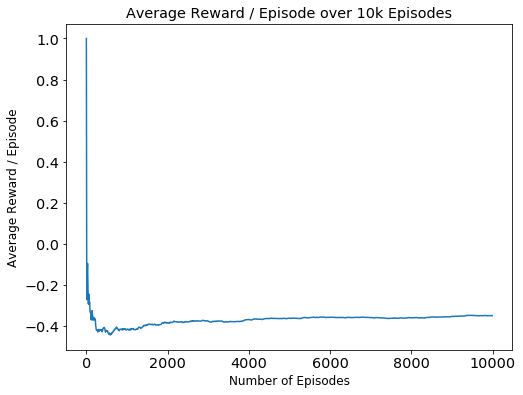

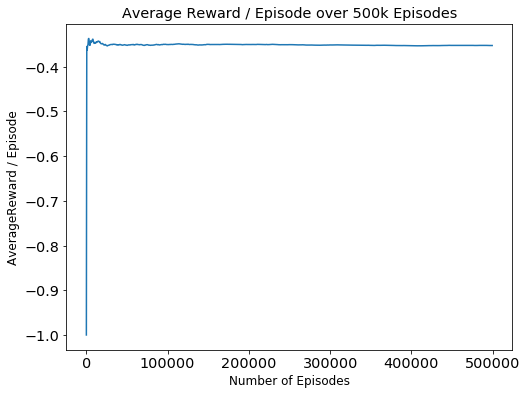

Overall Average Reward for Chosen Policy Using 10k Episodes: -0.3710
Overall Average Reward for Chosen Policy Using 500k Episodes: -0.3515


In [13]:
# b
# show plot of overall average reward / episode vs number 
# of episodes for both the 10k and the 500k cases

# plot for 10k case
plt.figure(figsize = (8, 6))
plt.title("Average Reward / Episode over 10k Episodes")
plt.ylabel("Average Reward / Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0, len(avgreward10k),10), [avgreward10k[i] for i in range(0,len(avgreward10k), 10)])
plt.show()

# Average reward for 10K Episodes
plt.figure(figsize = (8, 6))
plt.title("Average Reward / Episode over 500k Episodes")
plt.ylabel("AverageReward / Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0,len(avgreward500k),500), [avgreward500k[i] for i in range(0,len(avgreward500k), 500)])
plt.show()

# calculate the overall avg reward for this policy for each case
totalavgreward10k = np.sum(np.array(avgreward10k))/float(len(avgreward10k))
totalavgreward500k = np.sum(np.array(avgreward500k))/float(len(avgreward500k))
print("Overall Average Reward for Chosen Policy Using 10k Episodes: {:.4f}".format(totalavgreward10k))
print("Overall Average Reward for Chosen Policy Using 500k Episodes: {:.4f}".format(totalavgreward500k))

(b) continued -

Shown above are plots that show overall average reward per episode vs the number of episodes for both 10,000 simulations and 500,000 simulations. The first graph which displays 10k episodes in total, there is an notable period for the first eigth of the entire series that has a very high variance, however it does end up converging at an expected return value of -.34 around 750 episodes. The second graph showing 500k episodes, however, has much less obvious variance, and appears much more linear in general. Regardless of which case you choose, these two graphs suggest that with our policy, the house will always win. 

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 


**ANSWER**

In [14]:
# a
# using MC control through policy iteration, estimate optimal policy
# for playing our modified BJ game to maximize rewards

import sys
from scipy.stats import bernoulli
class MonteCarloControl():
    def __init__(self):
        self.discount = 1
        self.V = np.zeros((2, 22, 11, 2)); self.N = np.zeros((2,22, 11, 2))
        self.avg_rewards = [0]; self.game = Blackjack()

    def online_avg(self,old_avg, new_x, N):
        return new_x/N + ((N-1)/N) * old_avg

    def epsilon(self,N, N0 = 100):
        return N0/(N0 + N)

    def play_game(self):
        episode = []; player_sum, dealer_show, usable_ace = self.game.deal(); 
        usable_ace = int(usable_ace);
        while True:       
            action = np.argmax(self.V[usable_ace,player_sum,dealer_show])
            N_S = np.sum(self.N[usable_ace,player_sum,dealer_show])
            action = int(bernoulli.rvs(np.abs(action - self.epsilon(N_S,1000)), size = 1))
            episode.append((player_sum, usable_ace, action))
            (player_sum, dealer_show, usable_ace), reward, done = self.game.step(action)
            usable_ace = int(usable_ace)
            if done: break
        return episode, dealer_show, reward

    def update_avg(self,episode,dealer_show,reward):
        new_avg = self.online_avg(old_avg = self.avg_rewards[-1], new_x = reward,
                                  N = len(self.avg_rewards))
        self.avg_rewards.append(new_avg)
        for i, s in enumerate(episode):
            # Calculate discounted award based on number of states in episode
            num_steps = len(episode); discounted_reward = self.discount**(num_steps-i)*reward
            play_sum = s[0]; use_a = s[1]; act = s[2]
            new_avg = self.online_avg(old_avg=self.V[use_a,play_sum,dealer_show,act],
                                      new_x = discounted_reward,
                                      N = self.N[use_a,play_sum,dealer_show,act]+1)
            self.V[use_a,play_sum,dealer_show,act] = new_avg; 
            self.N[use_a,play_sum,dealer_show,act] += 1
        pass

    def mc_control(self,N=1000,discount=1):
        # run N simulations
        for i in range(N):
            if i % 1000 == 0:
                print("\rEpisode {}/{}.".format(i, N), end="")
                sys.stdout.flush()
            episode, dealer_show, reward = self.play_game()
            self.update_avg(episode, dealer_show,reward)
        return self.avg_rewards

mc = MonteCarloControl()
avg_rewards = mc.mc_control(N=5000000)

Episode 4999000/5000000.

<function matplotlib.pyplot.show(*args, **kw)>

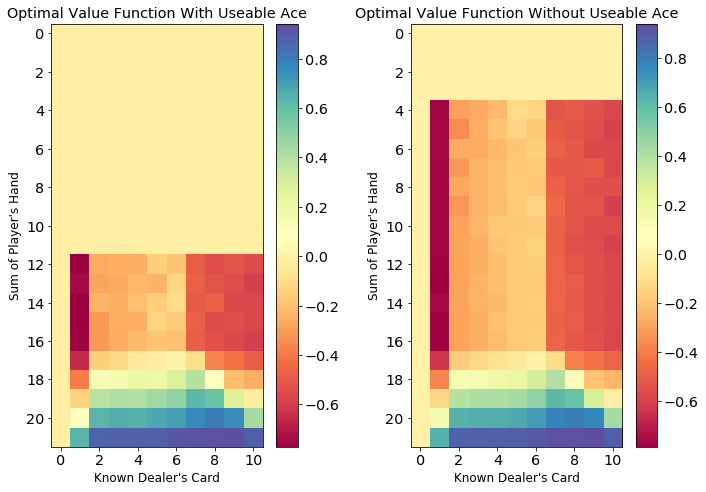

In [15]:
# a continued

# begin
plt.figure(figsize = (10,7))

# plot player's hand with useable A
plt.subplot(1,2,1)
plt.title("Optimal Value Function With Useable Ace")
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.xticks(np.arange(0, 11, step=2))
plt.yticks(np.arange(0, 22, step=2))
plt.imshow(mc.V[1,:,:,0],cmap='Spectral')
plt.colorbar()

# plot player's hand with un-useable A
plt.subplot(1,2,2)
plt.title("Optimal Value Function Without Useable Ace")
plt.xlabel("Known Dealer's Card")
plt.ylabel("Sum of Player's Hand")
plt.xticks(np.arange(0, 11, step=2))
plt.yticks(np.arange(0, 22, step=2))
plt.imshow(mc.V[0,:,:,0],cmap='Spectral')
plt.colorbar()

plt.tight_layout()
plt.show

(a part 1) continued - 

Shown above are plots of the optimal value function for each case, with and without a useable ace. These plots show that in both cases optimal values are positive when the player's hand sums to 18 or greater, and additionally when a player's hand sums to 17 or below, the values indicate that there would be a negative net reward and, when the dealer's card is 1 or greater than 6, these values are increasingly negative. 

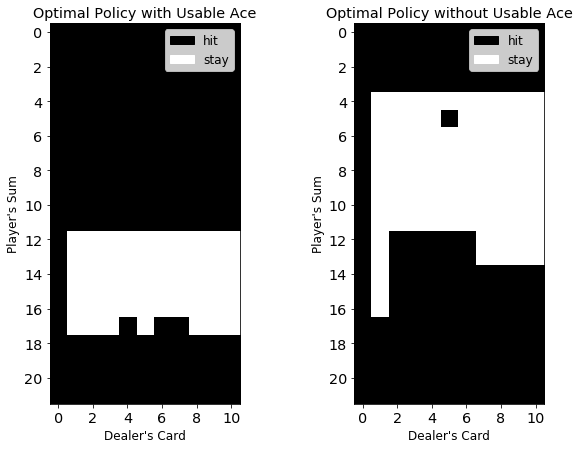

In [16]:
# a continued
import matplotlib.patches as mpatches

# begin
plt.figure(figsize = (10,7))

# plot the optimal policy with usuable acess
plt.subplot(1,2,1)
policy = np.zeros((22,11))
for ps in range(22):
    for dc in range(11):
        policy[ps,dc] = np.argmax(mc.V[1,ps,dc])
plt.title("Optimal Policy with Usable Ace")
plt.ylabel("Player's Sum"); plt.xlabel("Dealer's Card")
plt.xticks(np.arange(0, 11, step=2))
plt.yticks(np.arange(0, 22, step=2))
plt.imshow(policy,cmap='gray')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')
plt.legend(handles = [legend_hit,legend_stay])


plt.subplot(1,2,2)
policy = np.zeros((22,11))
for ps in range(22):
    for dc in range(11):
        policy[ps,dc] = np.argmax(mc.V[0,ps,dc])
plt.title("Optimal Policy without Usable Ace")
plt.ylabel("Player's Sum"); plt.xlabel("Dealer's Card")
plt.xticks(np.arange(0, 11, step=2))
plt.yticks(np.arange(0, 22, step=2))
plt.imshow(policy,cmap='gray')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')
plt.legend(handles = [legend_hit,legend_stay])
plt.show()

(a part 2) continued - 

The above plots show the optimal policy for states with and without the useable ace. The first graph where a useable ace is used seems to indicate that when a player's hand has value between 12 and 18, the player always chooses to hit except for the case where the dealer's known card is 7 and the player's hand sums to 17. At all other values, the player's optimal policy is to stay. Without the useable ace, though, the plot seems to indicate that an agent's best policy is to stay generally if their hand value is between 3 and 12, although this policy extends if the dealer's known card is a 1. Both plots may show an indication of some noise, which would suggest our model perhaps not having completely converged at 5 million simulations.

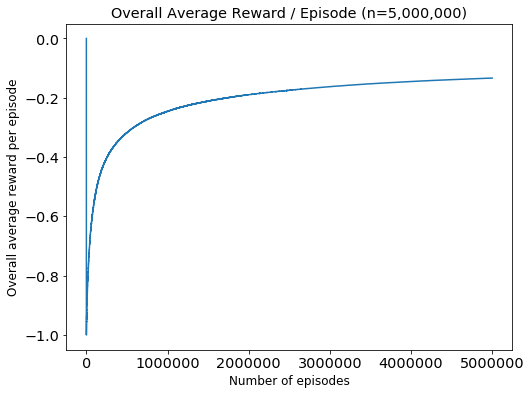

In [17]:
# b
# plot the overall avg reward / episode vs the number of episodes

plt.figure(figsize=(8,6))
plt.title("Overall Average Reward / Episode (n=5,000,000)")
plt.xlabel("Number of episodes")
plt.ylabel("Overall average reward per episode")
plt.plot(np.arange(len(avg_rewards)),avg_rewards)
plt.show()

In [18]:
print("Overall Average reward with monte carlo control: {}".format(sum(avg_rewards)/len(avg_rewards)))
print("Average reward at episode 5,000,000: {}".format(avg_rewards[len(avg_rewards)-1]))

Overall Average reward with monte carlo control: -0.20903312199280097
Average reward at episode 5,000,000: -0.13357379999998809


(b) continued - 

Our final plot shows overall average reward across episodes for our selected simulation value of 5 million, which does show convergence. After 5 million simulations our model appears to converge at around -0.1346. This model performed significantly better than a naive model.

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

(a) Given the above analysis and interpretation, between human control policy, naive policy, and the optimal control policy, the optimal control policy shown in question 3 using monte carlo control policy resulted in a overall average of -0.1325, whereas the naive policy resulted in a measurement of around -0.35 and, despite our measurement being 0.04 for the human policy, having run this model numerous times through that measure is not at all consistent and therefore does not generally perform the best. Another indication of this is that you can see in 3(b) this policy increases asymptotically to almost 0, where as the naive policy does converge to a linear place so while it is not a terrible model it is certainly does not perform as well as the monte carlo control, and as previously discusses our human policy did not converge to anywhere that we could see, thus making it completely unpredictable for how those 50 hands will turn out.

(b) Regardless of knowing the full Markov Decision Process for this environment, I do not believe a better policy could have been created if we are considering convergence as a feature of infinite time. This is due to the fact that regardless of the inital policy, the monte carlo policy will also converge to the optimal policy in infinite time. However, if we were considering only a finite set of time, MDP may be beneficial as it would allow the monte carlo policy to begin with an initial better policy.